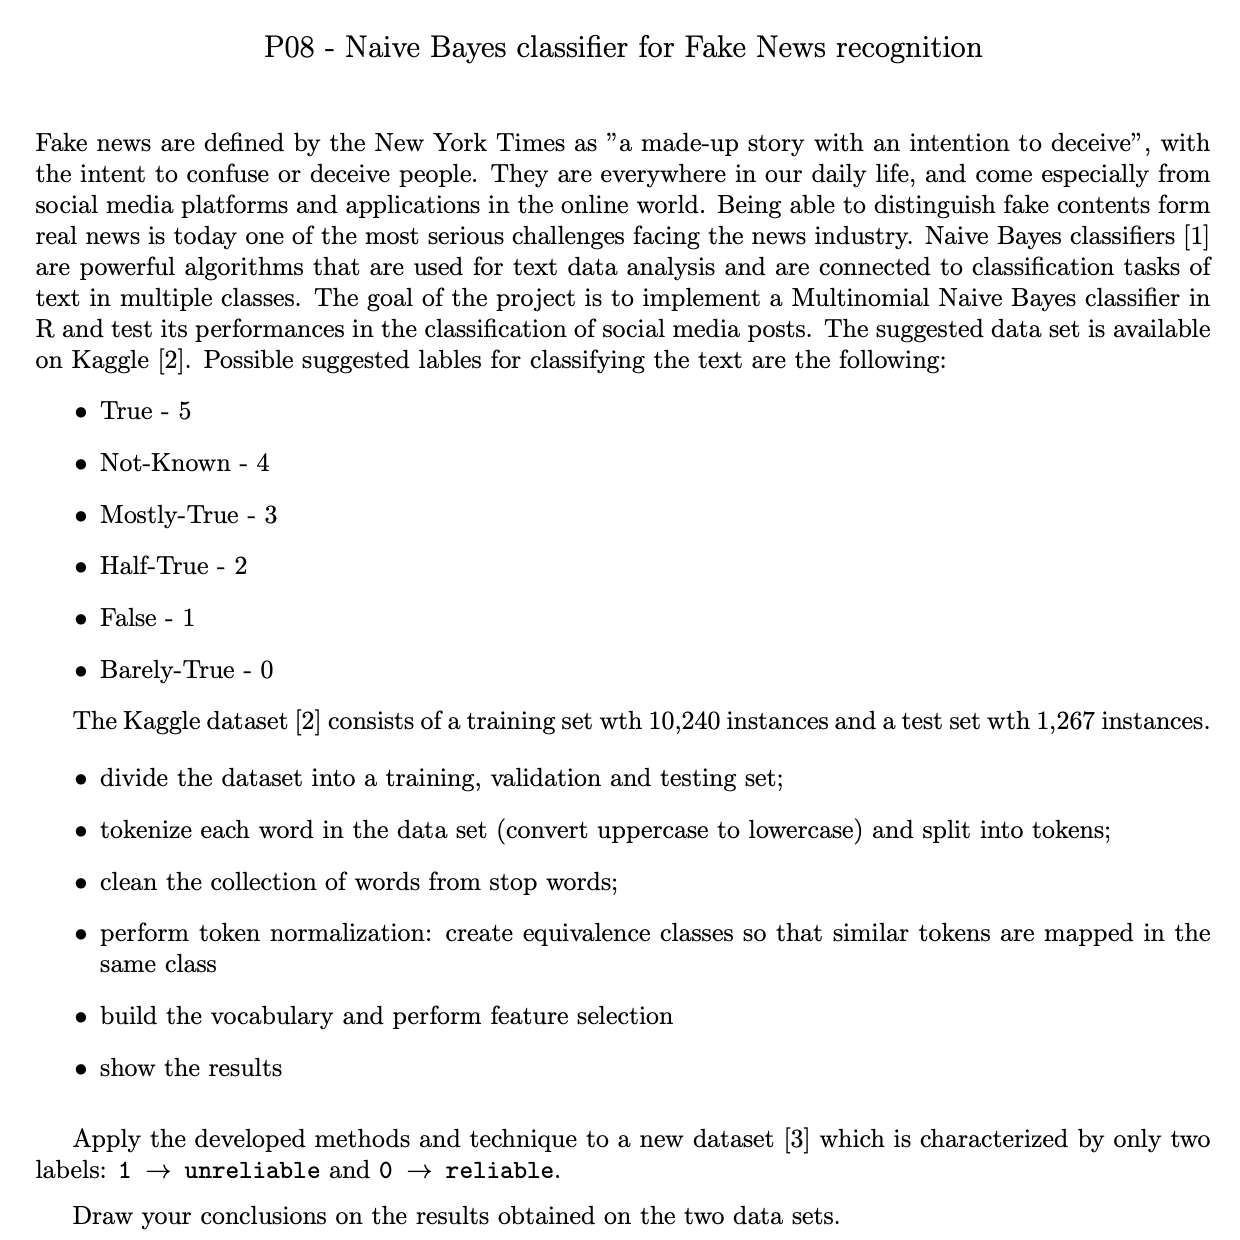

# Multinomial Naive Bayes Classifier

**Goal:** Classify a document *d* into one of *K* classes $C_k$, given its words.


## 1. Bayes' Theorem

$$
P(C_k \mid d) = \frac{P(d \mid C_k) \cdot P(C_k)}{P(d)}
$$

Since  $P(d)$ is constant across classes, we use:

$$
\arg\max_{C_k} \left[ P(d \mid C_k) \cdot P(C_k) \right]
$$


## 2. Multinomial Model

- Represent document *d* as a vector of word counts:  
- $ d = n_1, n_2, \dots, n_V $
- $V$ is the size of the vocabulary.
- $n_i$ is the number of times word $w_i$ appears in document *d*.

$$
P(d \mid C_k) = \frac{N_d!}{\prod_{i=1}^{V} n_i!} \prod_{i=1}^{V} \left( P(w_i \mid C_k) \right)^{n_i}
$$

In practice, we ignore the multinomial coefficient and compute:

$$
\log P(d \mid C_k) = \sum_{i=1}^{V} n_i \cdot \log P(w_i \mid C_k)
$$


## 3. Priors

$$
P(C_k) = \frac{\text{Number of documents in class } C_k}{\text{Total number of documents}}
$$


## 4. Likelihoods with Smoothing

$$
P(w_i \mid C_k) = \frac{N_{ik} + \alpha}{N_k + \alpha V}
$$

Where:

- $N_{ik}$ = number of times word $w_i$ occurs in documents of class $C_k$
- $N_k$ = total number of words in documents of class $C_k$
- $\alpha$ = smoothing parameter (usually $\alpha = 1$, Laplace smoothing)
- $V$ = size of vocabulary


## 5. Prediction Rule

For a given document *d*, compute for each class:

$$
\log P(C_k) + \sum_{i=1}^{V} n_i \cdot \log P(w_i \mid C_k)
$$

Choose the class with the highest score:

$$
\hat{C} = \arg\max_{C_k} \left[ \log P(C_k) + \sum_{i=1}^{V} n_i \cdot \log P(w_i \mid C_k) \right]
$$


## 6. Summary of Training Steps

1. Compute $P(C_k)$ for each class.
2. For each word $w_i$ and each class $C_k$, compute $P(w_i \mid C_k)$ with smoothing.


## 7. Summary of Prediction Steps

1. For a new document *d*, compute the score for each class.
2. Choose the class with the highest score.



---
# Load the datasets

In [29]:
# Load the required libraries
library(ggplot2)
library(tidytext)
library(dplyr)
library(tm)
library(tidyr)
library(SnowballC)

In [30]:
# Load the training and testing datasets
train_data = read.csv("data/train.csv")
test_data = read.csv("data/test.csv")

In [31]:
# Divide the training dataset into training and validation set. 20% of the data will be used for validation.

set.seed(123)  # For reproducibility

train_indices = sample(1:nrow(train_data), size = 0.8 * nrow(train_data))
train_data = train_data[train_indices, ]
validation_data = train_data[-train_indices, ]

In [32]:
print("--------- Training Data Summary ---------")
summarize(train_data,
          num_rows = n(), 
          num_cols = ncol(train_data),
          num_missing = sum(is.na(train_data)))

print("--------- Validation Data Summary ---------")
summarise(validation_data,
          num_rows = n(),
          num_cols = ncol(validation_data),
          num_missing = sum(is.na(validation_data)))

print("--------- Testing Data Summary ---------")
summarise(test_data,
          num_rows = n(),
          num_cols = ncol(test_data),
          num_missing = sum(is.na(test_data)))

[1] "--------- Training Data Summary ---------"


num_rows,num_cols,num_missing
<int>,<int>,<int>
8192,3,0


[1] "--------- Validation Data Summary ---------"


num_rows,num_cols,num_missing
<int>,<int>,<int>
1612,3,0


[1] "--------- Testing Data Summary ---------"


num_rows,num_cols,num_missing
<int>,<int>,<int>
1267,2,0


In [33]:
train_data = train_data %>% mutate(doc_id = row_number())
validation_data = validation_data %>% mutate(doc_id = row_number())
test_data = test_data %>% mutate(doc_id = row_number())

In [34]:
train_data$Text = as.character(train_data$Text)
validation_data$Text = as.character(validation_data$Text)
test_data$Text = as.character(test_data$Text)

In [35]:
train_data[0:5,]

,Labels,Text,Text_Tag,doc_id
,<int>,<chr>,<chr>,<int>
2463,4,Says Wisconsin Gov. Scott Walkers budget calls for raising property taxes by nearly $500 billion.,"state-budget,taxes",1
2511,5,Californias credit rating is the worst in the country.,"economy,message-machine,state-budget",2
8718,5,Michael Thurmond authored major legislation that has provided more than $250 million in tax relief to Georgias senior citizens and working families.,taxes,3
2986,3,"Palin ""fired Wasilla's Police Chief because he 'intimidated' her.""",crime,4
1842,5,[L]ess than one-tenth of Atlantas transportation needs are covered in a referendum to levy a 1-cent sales tax.,transportation,5


### Possible labels of the data
- False: 1
- Half-True: 2
- Mostly-True: 3
- Not-Known: 4
- True: 5
- Barely-True: 0

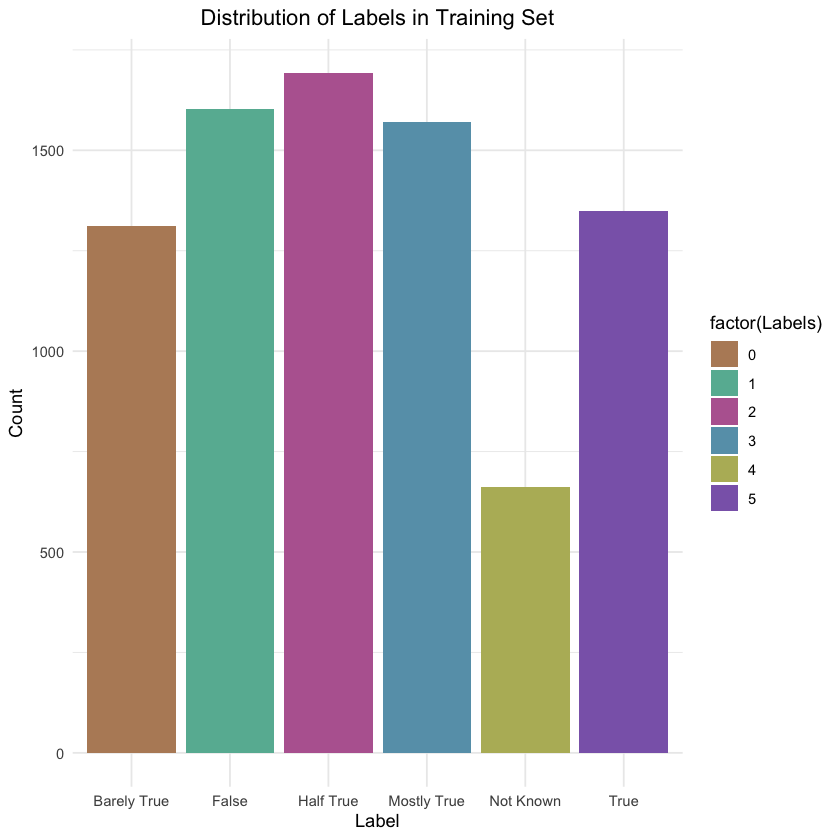

In [36]:
ggplot(train_data, aes(x = factor(Labels), fill = factor(Labels))) +
  geom_bar() +
  labs(title = "Distribution of Labels in Training Set",
       x = "Label",
       y = "Count") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5)) +
  scale_x_discrete(labels = c("0" = "Barely True", 
                               "1" = "False", 
                               "2" = "Half True", 
                               "3" = "Mostly True", 
                               "4" = "Not Known", 
                               "5" = "True")) +
  scale_fill_manual(values = c("0" = "#b78b67", 
                               "1" = "#67b7a1", 
                               "2" = "#b7679f", 
                               "3" = "#679fb7", 
                               "4" = "#b7b767", 
                               "5" = "#8b67b7"))

# Tokenization
We tokenize all of the datasets such that each datapoint will be a vector of the words it contains. All of the letters are converted into lowercase. The punctuation is removed. Stopwords such as "and", "of", or "the" are also removed. We replace numbers with a < number > placeholder unless it includes a dollar sign ($) or a percentage (%)

In [37]:
tokenize_and_clean_text <- function(data_frame) {
  data_frame %>% # nolint
    # Tokenize the text into individual words (from tidytext library)
    unnest_tokens(word, Text, drop = FALSE) %>%
    # Remove punctuation (uses regex to match punctuation characters)
    mutate(word = gsub("[[:punct:]]", "", word)) %>%
    # Replace numbers with a placeholder unless they start with $ or end with %
    mutate(word = ifelse(grepl("^\\$[0-9]+|[0-9]+%$", word), 
                         word, 
                         gsub("[[:digit:]]+", "<number>", word))) %>%
    # Create equivalence classes
    # mutate(word = wordStem(word, language = "en")) %>% # REDUCED THE VALIDATION ACCURACY BY 5% :OOOO
    # Remove English stopwords
    anti_join(stop_words, by = "word") %>%
    # Filter out any empty strings
    filter(word != "") %>%
    # Filter out single-character words
    filter(nchar(word) > 1)
}

In [38]:
create_dtm <- function(tokenized_data, total_docs = NULL, tfidf = FALSE, tfidf_power = 1.0) {
  if (!all(c("doc_id", "word") %in% colnames(tokenized_data))) {
    stop("The data must contain 'doc_id' and 'word' columns.")
  }

  if (!is.null(total_docs)) {
    all_doc_ids <- data.frame(doc_id = 1:total_docs)
    tokenized_data <- all_doc_ids %>%
      left_join(tokenized_data, by = "doc_id") %>%
      filter(!is.na(word) & word != "")
  }

  word_counts <- tokenized_data %>%
    count(doc_id, word)

  if (tfidf) {
    # Compute TF-IDF manually
    doc_freq <- word_counts %>%
      group_by(word) %>%
      summarise(df = n_distinct(doc_id), .groups = "drop")

    total_docs <- n_distinct(word_counts$doc_id)

    tf_idf <- word_counts %>%
      left_join(doc_freq, by = "word") %>%
      mutate(
        tf = n,
        idf = log((total_docs + 1) / (df + 1)) + 1,
        tf_idf = (tf * idf) ^ tfidf_power
      )

    dtm <- tf_idf %>%
      select(doc_id, word, tf_idf) %>%
      cast_sparse(doc_id, word, tf_idf)

  } else {
    dtm <- word_counts %>%
      cast_sparse(doc_id, word, n)
  }

  return(dtm)
}


In [39]:
prepare_pipeline <- function(train_data, validation_data, test_data,
                             min_freq = 5,
                             use_text_tag = TRUE,
                             use_tfidf = TRUE,
                             tfidf_power = 1.0) {
  
  # 1. Optionally add Text_Tag
  if (use_text_tag) {
    train_data <- train_data %>% mutate(Text = paste(Text, Text_Tag))
    validation_data <- validation_data %>% mutate(Text = paste(Text, Text_Tag))
    test_data <- test_data %>% mutate(Text = paste(Text, Text_Tag))
  }

  # 2. Tokenize
  tokenized_train_data <- tokenize_and_clean_text(train_data)
  tokenized_validation_data <- tokenize_and_clean_text(validation_data)
  tokenized_test_data <- tokenize_and_clean_text(test_data)

  # 3. Filter low-frequency vocab
  vocab <- tokenized_train_data %>%
    count(word) %>%
    filter(n >= min_freq) %>%
    pull(word)

  tokenized_train_data <- tokenized_train_data %>% filter(word %in% vocab)
  tokenized_validation_data <- tokenized_validation_data %>% filter(word %in% vocab)
  tokenized_test_data <- tokenized_test_data %>% filter(word %in% vocab)

  # 4. Create matrices with optional TF-IDF
  training_matrix <- create_dtm(tokenized_train_data, tfidf = use_tfidf, tfidf_power = tfidf_power)
  validation_matrix <- create_dtm(tokenized_validation_data, tfidf = use_tfidf, tfidf_power = tfidf_power)
  test_matrix <- create_dtm(tokenized_test_data, total_docs = nrow(test_data), tfidf = use_tfidf, tfidf_power = tfidf_power)

  # Coerce all to numeric matrices
  training_matrix <- as.matrix(training_matrix)
  validation_matrix <- as.matrix(validation_matrix)
  test_matrix <- as.matrix(test_matrix)
  

  return(list(
    training_matrix = training_matrix,
    validation_matrix = validation_matrix,
    test_matrix = test_matrix,
    vocab = vocab,
    tokenized_train_data = tokenized_train_data
  ))
}


# Naive Bayes Classifier Main Functions

In [40]:
predict_naive_bayes <- function(matrix, priors, log_likelihoods, classes) {
  predictions <- vector("character", nrow(matrix))
  vocab <- colnames(matrix)
  
  for (i in 1:nrow(matrix)) {
    doc <- as.numeric(matrix[i, ])
    names(doc) <- colnames(matrix)  # important for word-based lookup
    scores <- sapply(classes, function(class) {
      shared_words <- intersect(vocab, names(log_likelihoods[[class]]))
      if (length(shared_words) == 0) return(-Inf)
      sum(doc[shared_words] * log_likelihoods[[class]][shared_words]) + log(priors[class])
    })
    predictions[i] <- classes[which.max(scores)]
  }
  
  return(predictions)
}

train_naive_bayes <- function(training_matrix, train_labels,
                              validation_matrix, validation_labels,
                              laplace = 1.0) {
  training_matrix <- as.matrix(training_matrix)
  validation_matrix <- as.matrix(validation_matrix)

  train_labels <- as.factor(train_labels)
  validation_labels <- as.factor(validation_labels)
  classes <- levels(train_labels)

  priors <- table(train_labels) / length(train_labels)

  likelihoods <- list()
  for (class in classes) {
    class_rows <- training_matrix[train_labels == class, , drop = FALSE]
    word_totals <- colSums(class_rows) + laplace
    likelihoods[[class]] <- word_totals / sum(word_totals)
  }

  epsilon <- 1e-10
  vocab <- colnames(training_matrix)
  log_likelihoods <- list()
  for (class in classes) {
    log_likelihoods[[class]] <- sapply(vocab, function(word) {
      if (word %in% names(likelihoods[[class]])) {
        log(likelihoods[[class]][[word]])
      } else {
        log(epsilon)
      }
    })
  }

  validation_predictions <- predict_naive_bayes(validation_matrix,
                                                priors,
                                                log_likelihoods,
                                                classes)

  confusion_matrix <- table(Predicted = validation_predictions, Actual = validation_labels)
  accuracy <- sum(diag(confusion_matrix)) / sum(confusion_matrix)

  print("Confusion Matrix:")
  print(confusion_matrix)
  print(paste("Validation Accuracy:", round(accuracy * 100, 2), "%"))

  return(list(
    priors = priors,
    likelihoods = likelihoods,
    log_likelihoods = log_likelihoods,
    classes = classes,
    predictions = validation_predictions,
    confusion_matrix = confusion_matrix
  ))
}


# Varying hyperparameter configurations

In [41]:
# Define hyperparameter grid
min_freq_values     <- c(1, 2)
use_text_tag_values <- c(TRUE, FALSE)
use_tfidf_values    <- c(TRUE, FALSE)
laplace_values      <- c(0.5, 1.0)
tfidf_power_values  <- c(1.0, 2.0)

# Create an empty data frame to store results
results <- data.frame(
  min_freq = integer(),
  use_text_tag = logical(),
  use_tfidf = logical(),
  laplace = numeric(),
  tfidf_power = numeric(),
  validation_accuracy = numeric(),
  stringsAsFactors = FALSE
)

# Grid search loop
for (min_freq in min_freq_values) {
  for (use_text_tag in use_text_tag_values) {
    for (use_tfidf in use_tfidf_values) {
      for (laplace in laplace_values) {
        for (tfidf_power in tfidf_power_values) {
          cat("\n--- Running with:",
              "min_freq =", min_freq,
              "| use_text_tag =", use_text_tag,
              "| use_tfidf =", use_tfidf,
              "| laplace =", laplace,
              "| tfidf_power =", tfidf_power, "---\n")

          tryCatch({
            # Prepare matrices
            result <- prepare_pipeline(train_data, validation_data, test_data,
                                       min_freq = min_freq,
                                       use_text_tag = use_text_tag,
                                       use_tfidf = use_tfidf,
                                       tfidf_power = tfidf_power)

            # Align labels
            train_indices <- as.integer(rownames(result$training_matrix))
            val_indices   <- as.integer(rownames(result$validation_matrix))

            train_labels_aligned <- train_data$Labels[train_indices]
            val_labels_aligned   <- validation_data$Labels[val_indices]

            # Train
            model <- train_naive_bayes(result$training_matrix,
                                       train_labels_aligned,
                                       result$validation_matrix,
                                       val_labels_aligned,
                                       laplace = laplace)

            acc <- sum(diag(model$confusion_matrix)) / sum(model$confusion_matrix)

            # Save results
            results <- rbind(results, data.frame(
              min_freq = min_freq,
              use_text_tag = use_text_tag,
              use_tfidf = use_tfidf,
              laplace = laplace,
              tfidf_power = tfidf_power,
              validation_accuracy = round(acc * 100, 2)
            ))

          }, error = function(e) {
            cat("⚠️ Skipped config due to error:", e$message, "\n")
          })
        }
      }
    }
  }
}

# View results
print(results)



--- Running with: min_freq = 1 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.5 | tfidf_power = 1 ---
[1] "Confusion Matrix:"
         Actual
Predicted   0   1   2   3   4   5
        0 211  24  20  11   2   8
        1  12 224  12  11   1  17
        2  19  24 245  16   6  22
        3  16  17  21 234   5  15
        4   3   7   3   5 112   8
        5   9  21  15  21   2 213
[1] "Validation Accuracy: 76.86 %"

--- Running with: min_freq = 1 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.5 | tfidf_power = 2 ---
[1] "Confusion Matrix:"
         Actual
Predicted   0   1   2   3   4   5
        0 215  22  23  11   1  13
        1   8 234  14  17   0  15
        2  21  18 242  19   5  23
        3  11  19  18 227   6  12
        4   3   6   4   4 115   9
        5  12  18  15  20   1 211
[1] "Validation Accuracy: 77.17 %"

--- Running with: min_freq = 1 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 1 | tfidf_power = 1 ---
[1] "Confusion Matrix:"
         Actual
Pre

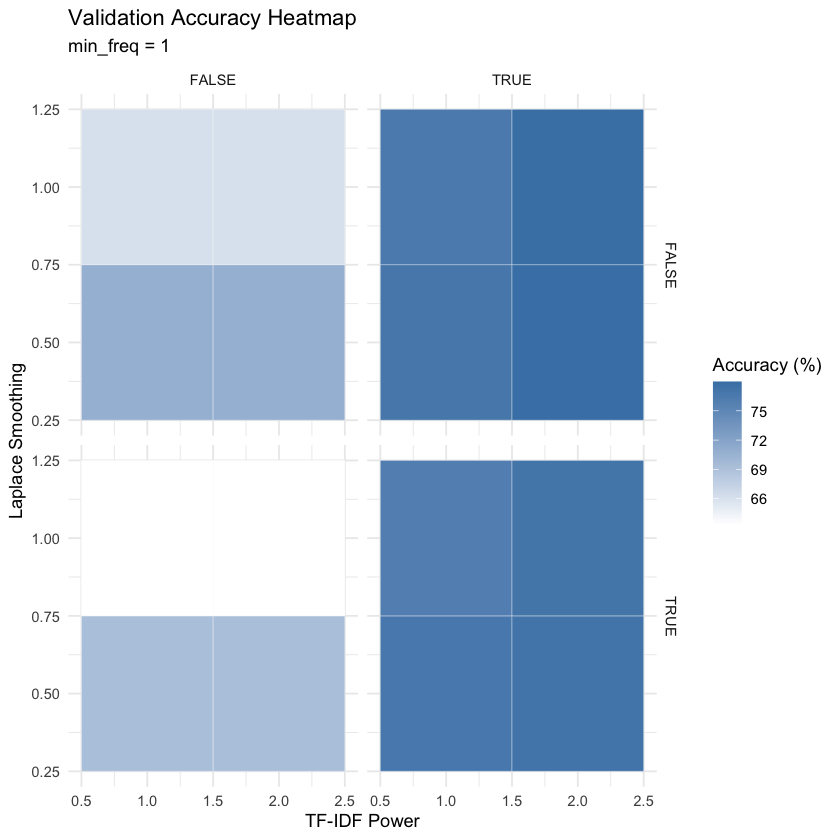

In [45]:
library(ggplot2)

# Filter to a specific min_freq
subset_results <- results[results$min_freq == 1, ]

ggplot(subset_results, aes(x = tfidf_power, y = laplace, fill = validation_accuracy)) +
  geom_tile(color = "white") +
  facet_grid(use_text_tag ~ use_tfidf) +
  scale_fill_gradient(low = "white", high = "steelblue") +
  labs(
    title = "Validation Accuracy Heatmap",
    subtitle = "min_freq = 1",
    x = "TF-IDF Power",
    y = "Laplace Smoothing",
    fill = "Accuracy (%)"
  ) +
  theme_minimal()


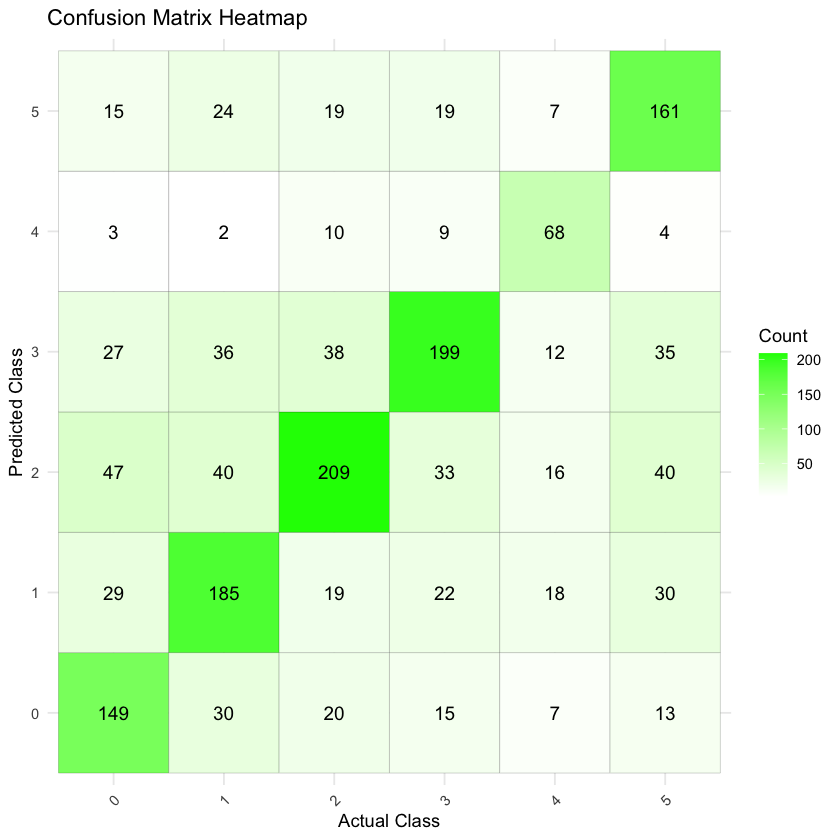

In [43]:
confusion_matrix = model$confusion_matrix

cm_df <- as.data.frame(confusion_matrix)
colnames(cm_df) <- c("Predicted", "Actual", "Count")

ggplot(cm_df, aes(x = Actual, y = Predicted, fill = Count)) +
  geom_tile(color = "black", linewidth = 0.05) +
  geom_text(aes(label = Count), color = "black", size = 4) +
  scale_fill_gradient(low = "white", high = "green") +
  theme_minimal() +
  labs(title = "Confusion Matrix Heatmap",
       x = "Actual Class",
       y = "Predicted Class") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


# Test evaluation

In [44]:
test_predictions <- predict_naive_bayes(test_matrix, 
                                        model$priors, 
                                        model$log_likelihoods, 
                                        model$classes)

ERROR: Error: 'test_matrix' nesnesi bulunamadi


In [248]:
table(test_predictions)

test_predictions
  0   1   2   3   4   5 
174 244 300 293  67 189 

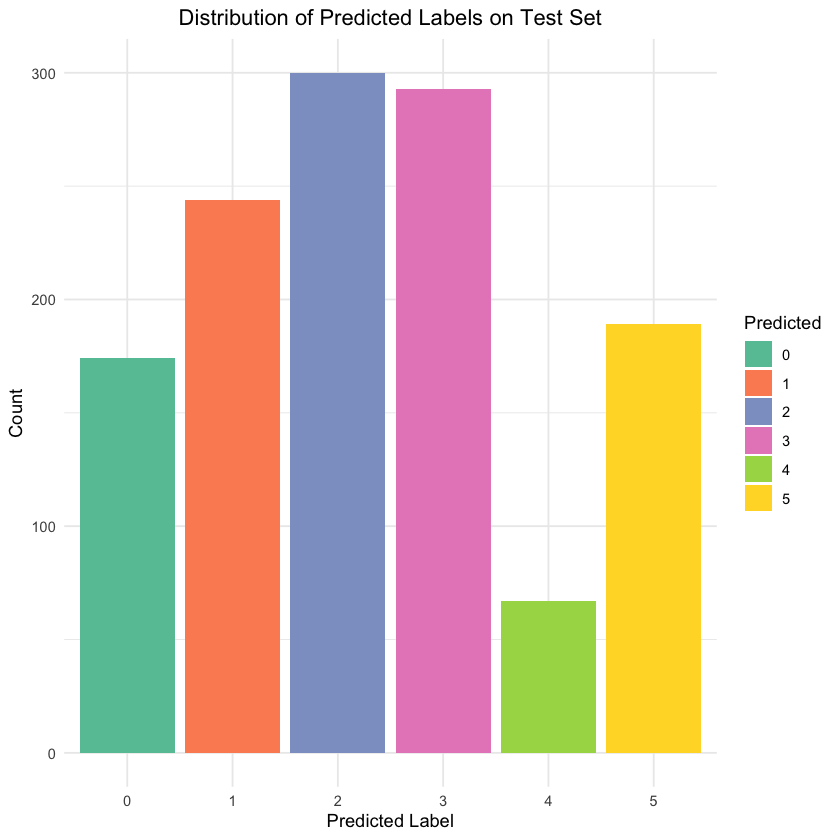

In [249]:
library(ggplot2)

# Convert to data frame
pred_df <- data.frame(Predicted = test_predictions)

# Plot
ggplot(pred_df, aes(x = Predicted, fill = Predicted)) +
  geom_bar() +
  labs(title = "Distribution of Predicted Labels on Test Set",
       x = "Predicted Label",
       y = "Count") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5)) +
  scale_fill_brewer(palette = "Set2")
